In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.patches as patches

# Define parameters
year = 2014 # 2014, 2015, 2016, 2017
market_demands = ['high', 'moderate', 'low'] # High, moderate, and low demand

# --- Step 1: Read the full data for the year to get global min/max ---
file_name = '../data/processed/simulations/simulations_apr7.parquet'
df_full_year = pd.read_parquet(file_name)
df_full_year = df_full_year[df_full_year['Year'] == year]

# --- Step 2: Determine global color scale limits for the entire year ---
v_min = df_full_year['Mean Profit Percent Change'].min()
v_max = df_full_year['Mean Profit Percent Change'].max()
print(f"Global Min/Max for {year}: {v_min:.2f}%, {v_max:.2f}%") # Optional: print the range

# --- Step 3: Filter the data for all three market demands ---
df_profit_high = df_full_year[df_full_year['Market Demand'] == 'high'].copy()
df_profit_moderate = df_full_year[df_full_year['Market Demand'] == 'moderate'].copy()
df_profit_low = df_full_year[df_full_year['Market Demand'] == 'low'].copy()

# Convert 'Quantile' to string type for consistent labeling
df_profit_high['Quantile'] = df_profit_high['Quantile'].astype(str)
df_profit_moderate['Quantile'] = df_profit_moderate['Quantile'].astype(str)
df_profit_low['Quantile'] = df_profit_low['Quantile'].astype(str)

# Get sorted unique V6 Percent and Initial Probability values (using high demand as reference)
unique_v6_percent = sorted(df_profit_high['V6 Percent'].unique())
unique_init_prob = sorted(df_profit_high['Initial Probability'].unique())

# **Format initial probabilities without trailing zeros**
def format_prob(prob, decimal_places=5):
    formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
    return formatted if formatted else '0'

unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

# Define the grid size
n_rows_per_demand = len(unique_v6_percent)  # Rows per demand scenario
n_cols = len(unique_init_prob)
n_demand_scenarios = len(market_demands)
total_rows = n_rows_per_demand * n_demand_scenarios  # Total rows for both demand scenarios

# --- Step 4: Set up the figure and subplots ---
fig, axes = plt.subplots(total_rows, n_cols, figsize=(3*n_cols, 2.5*total_rows))
if total_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Use a colorblind-friendly colormap (viridis is similar to Plotly's cividis)
cmap = 'viridis'  # Other options: 'plasma', 'cividis', 'inferno'

# Create a normalization object for consistent color scaling
norm = Normalize(vmin=v_min, vmax=v_max)

# --- Step 5: Create heatmaps for each subplot ---
for demand_idx, market_demand in enumerate(market_demands):
    # Select the appropriate dataframe
    if market_demand == 'high':
        df_profit_all = df_profit_high
    elif market_demand == 'moderate':
        df_profit_all = df_profit_moderate
    else:  # low demand
        df_profit_all = df_profit_low
    
    for i, v6_value in enumerate(unique_v6_percent):
        for j, init_prob_value in enumerate(unique_init_prob):
            # Filter the dataframe for the current combination
            df_filtered = df_profit_all[
                (df_profit_all['V6 Percent'] == v6_value) &
                (df_profit_all['Initial Probability'] == init_prob_value)
            ]
            
            # Pivot the data for heatmap
            pivot_profit = df_filtered.pivot_table(
                values='Mean Profit Percent Change',
                index='Quantile',
                columns='Sprays in May',
                aggfunc="mean"
            ).sort_index(axis=1)
            
            # Ensure columns are sorted numerically
            pivot_profit = pivot_profit.sort_index(axis=1)
            
            # Calculate row position (demand_idx * n_rows_per_demand + i)
            row_pos = demand_idx * n_rows_per_demand + i
            
            # Create heatmap
            ax = axes[row_pos, j]
            sns.heatmap(
                pivot_profit,
                ax=ax,
                cmap=cmap,
                vmin=v_min,
                vmax=v_max,
                cbar=False,  # We'll add a single colorbar later
                linewidths=0.5,
                linecolor='white',
                square=True,  # Make squares perfectly square
                annot=False,
                fmt='.1f'
            )
            
            # Customize individual subplot
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            
            # Remove any padding/margins from individual axes
            ax.set_xlim([0, pivot_profit.shape[1]])
            ax.set_ylim([0, pivot_profit.shape[0]])
            
            # Only show x-axis labels on bottom row
            if row_pos < total_rows - 1:
                ax.set_xticklabels([])
            
            # Only show y-axis labels on leftmost column
            if j > 0:
                ax.set_yticklabels([])

# --- Step 6: Add labels and title ---
# Main title
fig.suptitle(f'Relative Change in Profit for High, Moderate, and Low Market Demand in {year}', 
             fontsize=16, fontweight='bold', y=0.96)

# Add column headers (Initial Probability) - only at the top
for j, init_prob_label in enumerate(unique_init_prob_labels):
    fig.text((j + 0.5) / n_cols, 0.94, f"p₀ = {init_prob_label}", 
             ha='center', va='center', fontsize=10, fontweight='bold')

# Add "Initial Probability of Disease" label
fig.text(0.5, 0.95, "Initial Probability of Disease", 
         ha='center', va='center', fontsize=12, fontweight='bold')

# Add demand scenario labels
fig.text(0.02, 0.83, "High\nDemand", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=0)
fig.text(0.02, 0.50, "Moderate\nDemand", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=0)
fig.text(0.02, 0.17, "Low\nDemand", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=0)

# Add row labels (% V6) for both demand scenarios
for demand_idx, market_demand in enumerate(market_demands):
    for i, v6_value in enumerate(unique_v6_percent):
        row_pos = demand_idx * n_rows_per_demand + i
        y_pos = 1 - (row_pos + 0.5) / total_rows
        fig.text(0.08, y_pos, f"{int(v6_value * 100)}%", 
                 ha='center', va='center', fontsize=10, fontweight='bold', rotation=0)

# Add "% V6" label
fig.text(0.05, 0.5, "% V6", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=90)

# Add shared axis labels
fig.text(0.5, 0.02, "Number of Sprays in May", ha='center', va='center', 
         fontsize=12, fontweight='bold')
fig.text(0.09, 0.5, "Percentile of Dispersal-Centrality", ha='center', va='center', 
         fontsize=12, fontweight='bold', rotation=90)

# --- Step 7: Add colorbar ---
# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Profit % Change\n(Entire Year Range)', fontsize=10, fontweight='bold')
cbar.ax.tick_params(labelsize=9)

# Adjust layout
plt.subplots_adjust(left=0.12, right=0.9, top=0.92, bottom=0.05, 
                    wspace=0.05, hspace=0.01)

# Save the figure BEFORE showing it
plt.savefig('../reports/figures/profit_heatmap_high_moderate_low_demand_2014.png', 
            dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

Global Min/Max for 2014: -11.34%, 0.37%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.patches as patches

# Define parameters
year = 2014 # 2014, 2015, 2016, 2017
market_demands = ['high', 'moderate', 'low'] # High, moderate, and low demand

# --- Step 1: Read the full data for the year to get global min/max ---
file_name = '../data/processed/simulations/simulations_apr7.parquet'
df_full_year = pd.read_parquet(file_name)
df_full_year = df_full_year[df_full_year['Year'] == year]

# --- Step 2: Determine global color scale limits for the entire year ---
v_min = df_full_year['Mean Profit Percent Change'].min()
v_max = df_full_year['Mean Profit Percent Change'].max()
print(f"Global Min/Max for {year}: {v_min:.2f}%, {v_max:.2f}%") # Optional: print the range

# --- Step 3: Filter the data for all three market demands ---
df_profit_high = df_full_year[df_full_year['Market Demand'] == 'high'].copy()
df_profit_moderate = df_full_year[df_full_year['Market Demand'] == 'moderate'].copy()
df_profit_low = df_full_year[df_full_year['Market Demand'] == 'low'].copy()

# Convert 'Quantile' to string type for consistent labeling
df_profit_high['Quantile'] = df_profit_high['Quantile'].astype(str)
df_profit_moderate['Quantile'] = df_profit_moderate['Quantile'].astype(str)
df_profit_low['Quantile'] = df_profit_low['Quantile'].astype(str)

# Get sorted unique V6 Percent and Initial Probability values (using high demand as reference)
unique_v6_percent = sorted(df_profit_high['V6 Percent'].unique())
unique_init_prob = sorted(df_profit_high['Initial Probability'].unique())

# **Format initial probabilities without trailing zeros**
def format_prob(prob, decimal_places=5):
    formatted = f"{prob:.{decimal_places}f}".rstrip('0').rstrip('.')
    return formatted if formatted else '0'

unique_init_prob_labels = [format_prob(prob) for prob in unique_init_prob]

# Define the grid size
n_rows_per_demand = len(unique_v6_percent)  # Rows per demand scenario
n_cols = len(unique_init_prob)
n_demand_scenarios = len(market_demands)
total_rows = n_rows_per_demand * n_demand_scenarios  # Total rows for both demand scenarios

# Pre-compute all pivot tables to avoid recalculating during layout iterations
pivot_data = {}
for demand_idx, market_demand in enumerate(market_demands):
    # Select the appropriate dataframe
    if market_demand == 'high':
        df_profit_all = df_profit_high
    elif market_demand == 'moderate':
        df_profit_all = df_profit_moderate
    else:  # low demand
        df_profit_all = df_profit_low
    
    for i, v6_value in enumerate(unique_v6_percent):
        for j, init_prob_value in enumerate(unique_init_prob):
            # Filter the dataframe for the current combination
            df_filtered = df_profit_all[
                (df_profit_all['V6 Percent'] == v6_value) &
                (df_profit_all['Initial Probability'] == init_prob_value)
            ]
            
            # Pivot the data for heatmap
            pivot_profit = df_filtered.pivot_table(
                values='Mean Profit Percent Change',
                index='Quantile',
                columns='Sprays in May',
                aggfunc="mean"
            ).sort_index(axis=1)
            
            # Ensure columns are sorted numerically
            pivot_profit = pivot_profit.sort_index(axis=1)
            
            # Store in dictionary with key (demand_idx, i, j)
            pivot_data[(demand_idx, i, j)] = pivot_profit

print("Data processing complete! Now you can quickly iterate on the plotting below.")

Global Min/Max for 2014: -11.34%, 0.37%
Data processing complete! Now you can quickly iterate on the plotting below.


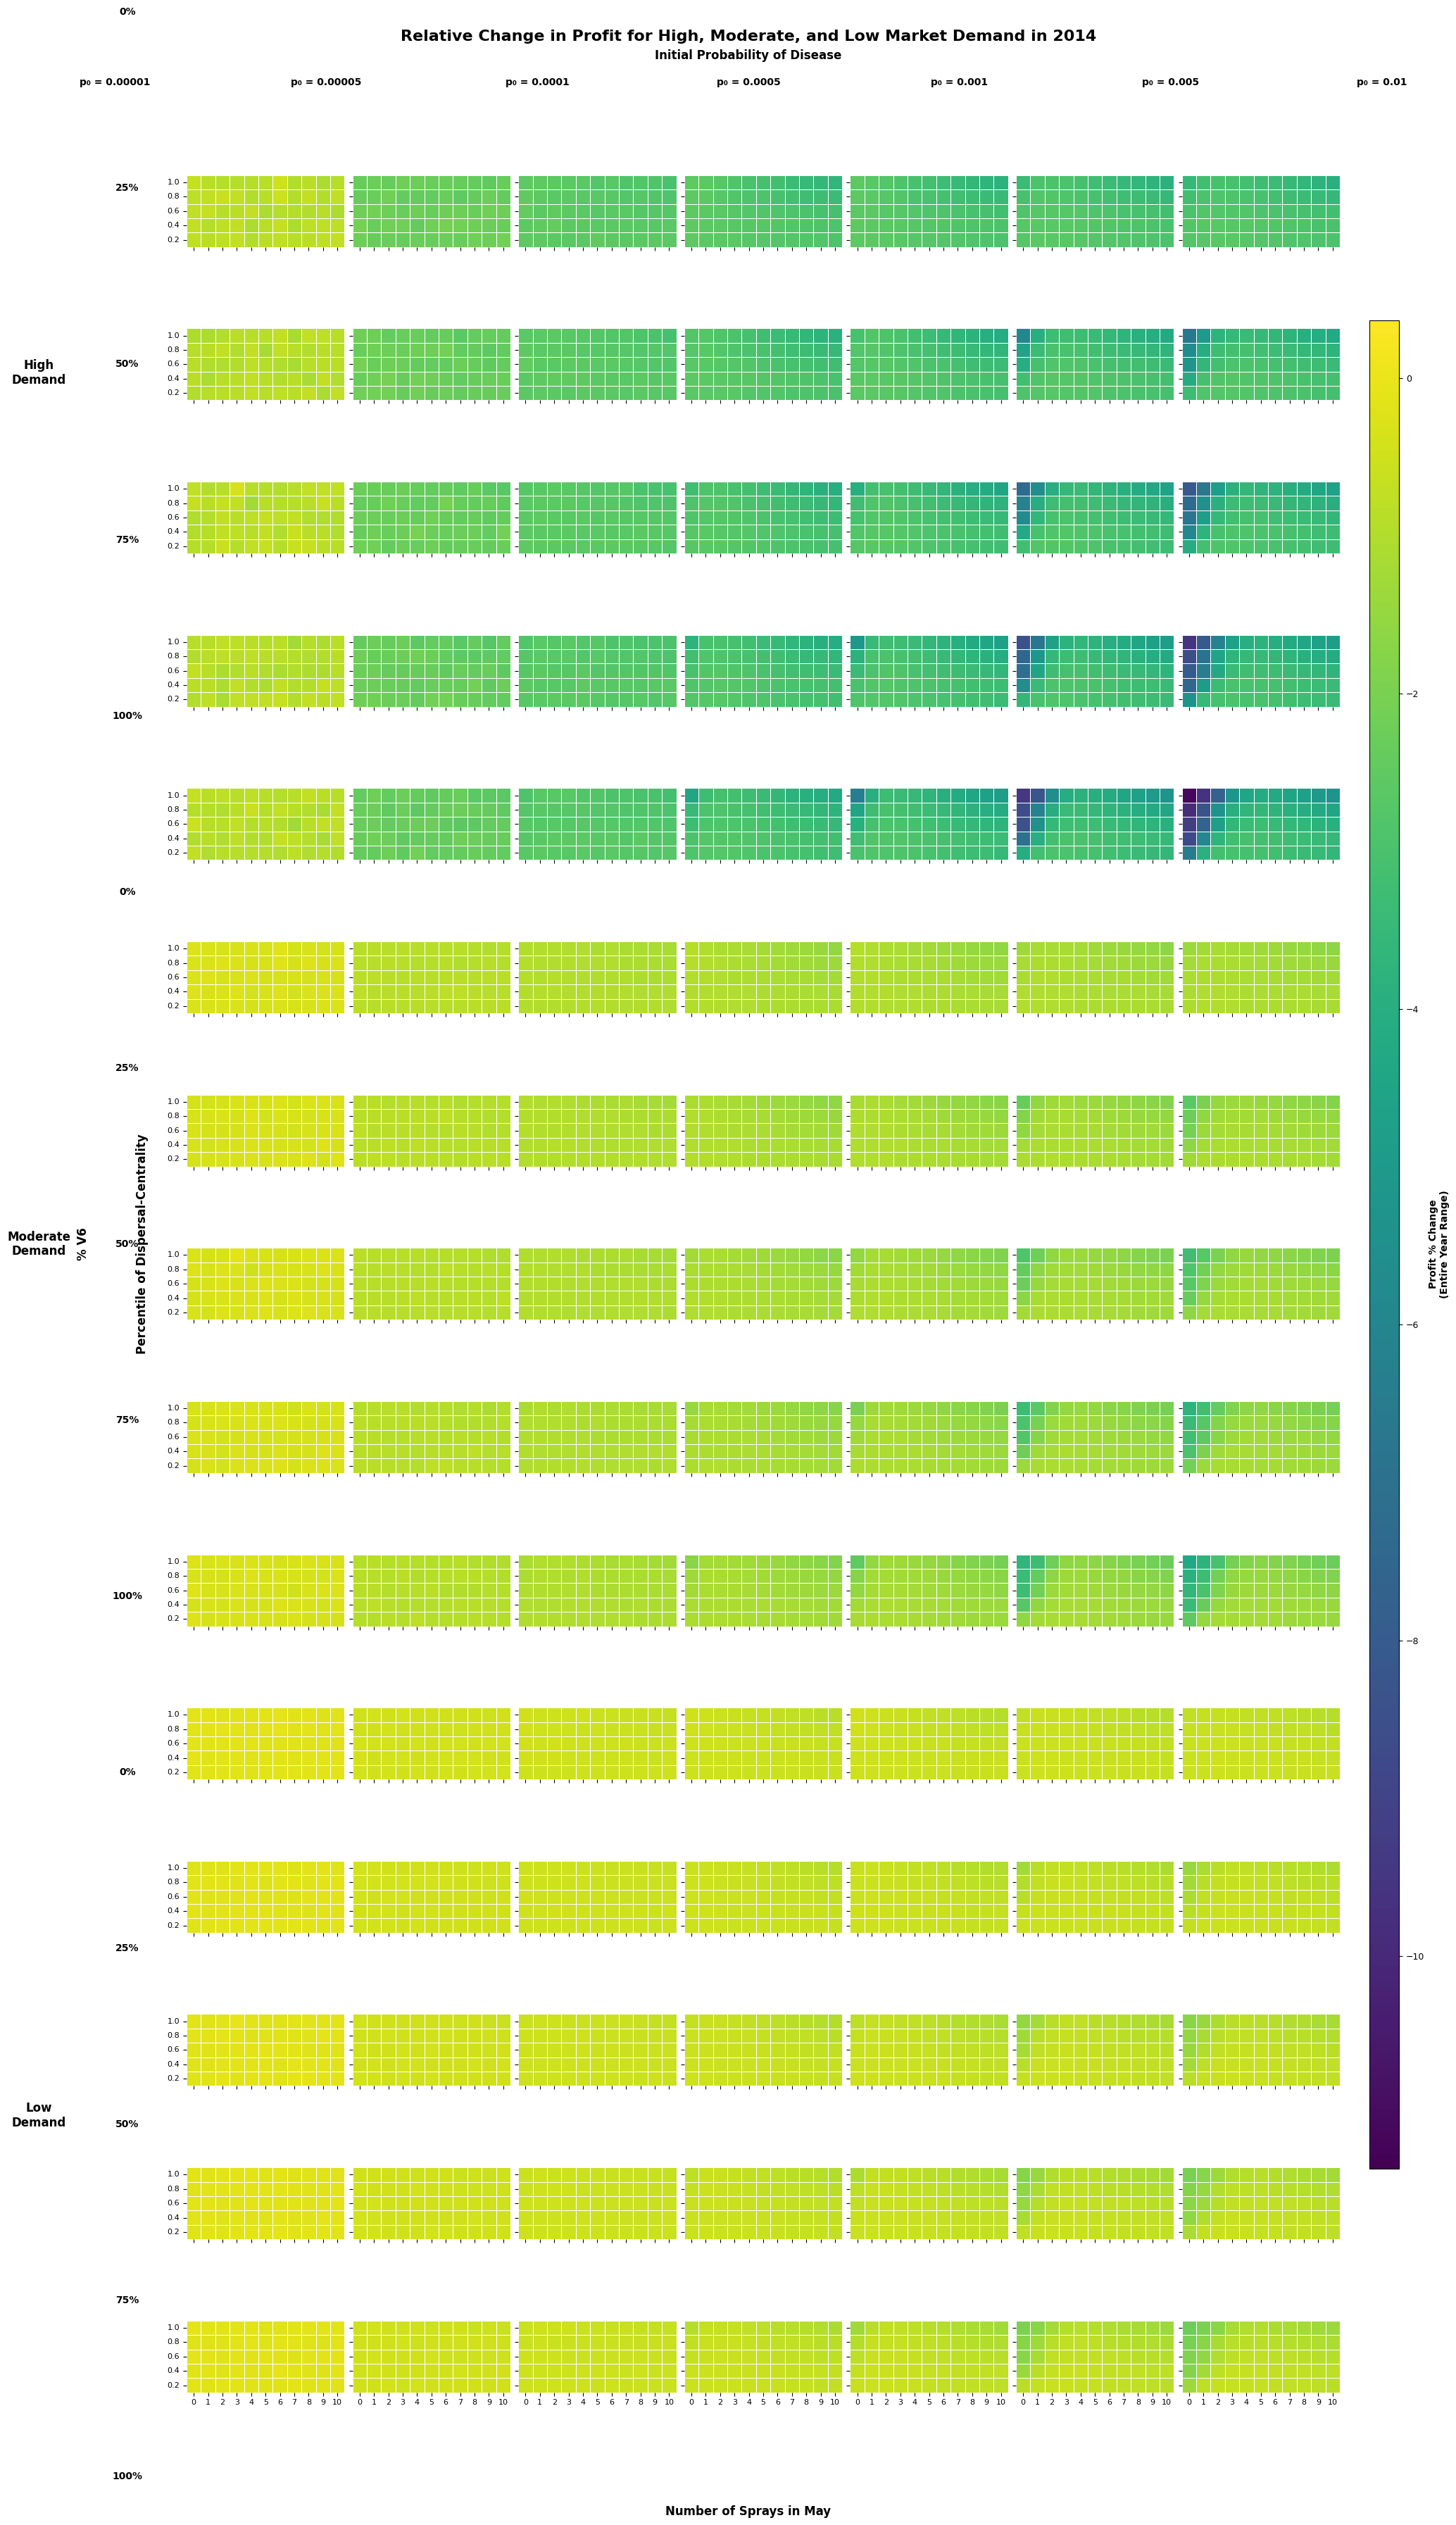

In [7]:
# --- FAST PLOTTING CELL - Run this to quickly iterate on layout ---
# Use a colorblind-friendly colormap (viridis is similar to Plotly's cividis)
cmap = 'viridis'  # Other options: 'plasma', 'cividis', 'inferno'

# Create a normalization object for consistent color scaling
norm = Normalize(vmin=v_min, vmax=v_max)

# --- Step 4: Set up the figure and subplots ---
# Store figure globally so layout adjustment cell can access it
global current_fig, current_axes
current_fig, current_axes = plt.subplots(total_rows, n_cols, figsize=(3*n_cols, 2.5*total_rows))
fig, axes = current_fig, current_axes

if total_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# --- Step 5: Create heatmaps for each subplot (using pre-computed data) ---
for demand_idx, market_demand in enumerate(market_demands):
    for i, v6_value in enumerate(unique_v6_percent):
        for j, init_prob_value in enumerate(unique_init_prob):
            # Get pre-computed pivot data
            pivot_profit = pivot_data[(demand_idx, i, j)]
            
            # Calculate row position (demand_idx * n_rows_per_demand + i)
            row_pos = demand_idx * n_rows_per_demand + i
            
            # Create heatmap
            ax = axes[row_pos, j]
            sns.heatmap(
                pivot_profit,
                ax=ax,
                cmap=cmap,
                vmin=v_min,
                vmax=v_max,
                cbar=False,  # We'll add a single colorbar later
                linewidths=0.5,
                linecolor='white',
                square=True,  # Make squares perfectly square
                annot=False,
                fmt='.1f'
            )
            
            # Customize individual subplot
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.tick_params(axis='x', labelsize=8)
            ax.tick_params(axis='y', labelsize=8)
            
            # Remove any padding/margins from individual axes
            ax.set_xlim([0, pivot_profit.shape[1]])
            ax.set_ylim([0, pivot_profit.shape[0]])
            
            # Only show x-axis labels on bottom row
            if row_pos < total_rows - 1:
                ax.set_xticklabels([])
            
            # Only show y-axis labels on leftmost column
            if j > 0:
                ax.set_yticklabels([])

# --- Step 6: Add labels and title ---
# Main title
fig.suptitle(f'Relative Change in Profit for High, Moderate, and Low Market Demand in {year}', 
             fontsize=16, fontweight='bold', y=0.96)

# Add column headers (Initial Probability) - only at the top
for j, init_prob_label in enumerate(unique_init_prob_labels):
    fig.text((j + 0.5) / n_cols, 0.94, f"p₀ = {init_prob_label}", 
             ha='center', va='center', fontsize=10, fontweight='bold')

# Add "Initial Probability of Disease" label
fig.text(0.5, 0.95, "Initial Probability of Disease", 
         ha='center', va='center', fontsize=12, fontweight='bold')

# Add demand scenario labels
fig.text(0.02, 0.83, "High\nDemand", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=0)
fig.text(0.02, 0.50, "Moderate\nDemand", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=0)
fig.text(0.02, 0.17, "Low\nDemand", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=0)

# Add row labels (% V6) for both demand scenarios
for demand_idx, market_demand in enumerate(market_demands):
    for i, v6_value in enumerate(unique_v6_percent):
        row_pos = demand_idx * n_rows_per_demand + i
        y_pos = 1 - (row_pos + 0.5) / total_rows
        fig.text(0.08, y_pos, f"{int(v6_value * 100)}%", 
                 ha='center', va='center', fontsize=10, fontweight='bold', rotation=0)

# Add "% V6" label
fig.text(0.05, 0.5, "% V6", ha='center', va='center', fontsize=12, 
         fontweight='bold', rotation=90)

# Add shared axis labels
fig.text(0.5, 0.02, "Number of Sprays in May", ha='center', va='center', 
         fontsize=12, fontweight='bold')
fig.text(0.09, 0.5, "Percentile of Dispersal-Centrality", ha='center', va='center', 
         fontsize=12, fontweight='bold', rotation=90)

# --- Step 7: Add colorbar ---
# Create a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Profit % Change\n(Entire Year Range)', fontsize=10, fontweight='bold')
cbar.ax.tick_params(labelsize=9)

# *** ADJUST THESE VALUES TO EXPERIMENT WITH LAYOUT ***
plt.subplots_adjust(left=0.12, right=0.9, top=0.92, bottom=0.05, 
                    wspace=0.05, hspace=0.01)

# Save the figure BEFORE showing it
# plt.savefig('../reports/figures/profit_heatmap_high_moderate_low_demand_2014.png', 
#             dpi=300, bbox_inches='tight', facecolor='white')

# Show the plot
plt.show()

In [ ]:
# *** SUPER FAST LAYOUT ADJUSTMENT CELL ***
# Run this cell to quickly adjust subplot spacing without regenerating the plot
# (Make sure you've run the plotting cell above first)

# Experiment with these values:
left = 0.12     # Left margin
right = 0.9     # Right margin  
top = 0.5      # Top margin
bottom = 0.05   # Bottom margin
wspace = 0.05   # Width spacing between subplots
hspace = 0.01   # Height spacing between subplots

# Use the stored figure from the plotting cell
try:
    # Adjust the layout of the stored figure
    current_fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom, 
                               wspace=wspace, hspace=hspace)
    
    # Clear any existing plots and display the updated figure
    plt.close('all')  # Close any other figures
    plt.figure(current_fig.number)  # Make current_fig the active figure
    current_fig.canvas.draw()  # Force redraw
    plt.show(current_fig)  # Show the specific figure
    
except NameError:
    print("Please run the plotting cell above first to create the figure!")
except Exception as e:
    print(f"Error: {e}")
    print("Please run the plotting cell above first.")

<Figure size 640x480 with 0 Axes>

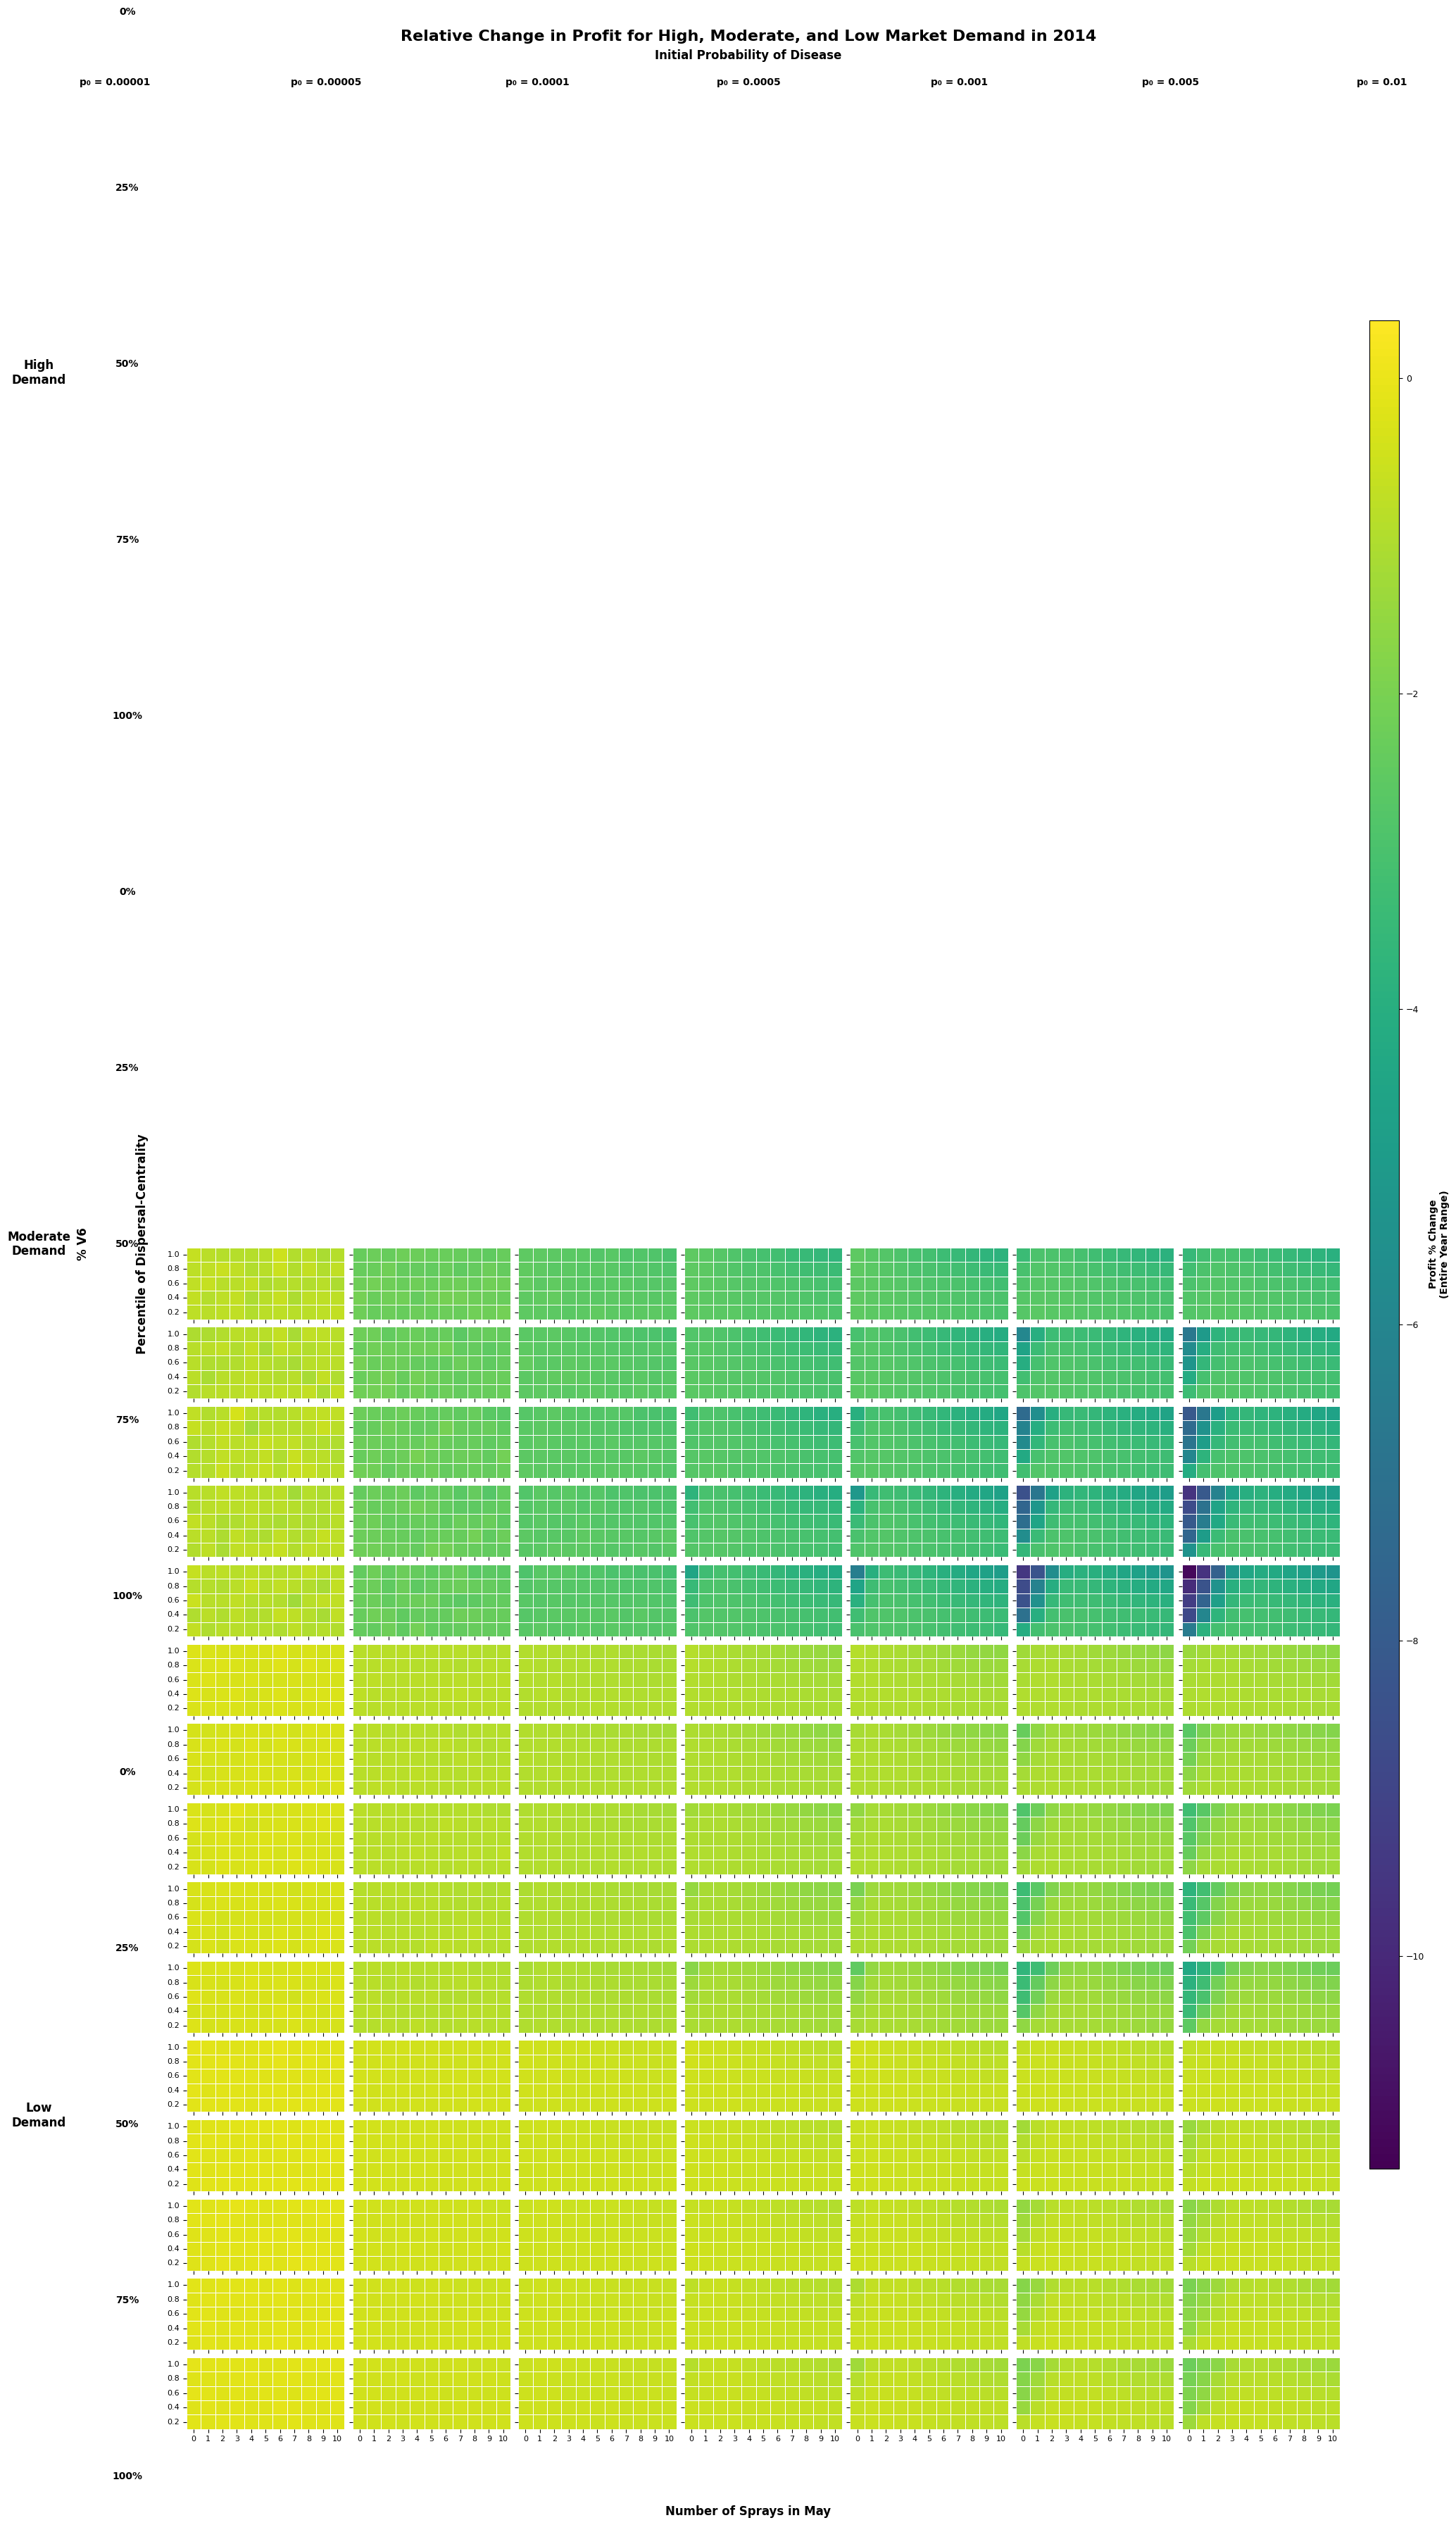

In [19]:
# *** ALTERNATIVE: INSTANT LAYOUT REFRESH ***
# This approach copies the existing figure and applies new layout

# Experiment with these values:
left = 0.12     # Left margin
right = 0.9     # Right margin  
top = 0.5      # Top margin
bottom = 0.05   # Bottom margin
wspace = 0.05   # Width spacing between subplots
hspace = 0.01   # Height spacing between subplots

try:
    # Get the current figure and copy its content
    import copy
    
    # Apply layout changes to the current figure
    current_fig.subplots_adjust(left=left, right=right, top=top, bottom=bottom, 
                               wspace=wspace, hspace=hspace)
    
    # Force matplotlib to refresh the display
    from IPython.display import display, clear_output
    clear_output(wait=True)
    display(current_fig)
    
except NameError:
    print("Please run the plotting cell (Cell 3) first to create the figure!")
except Exception as e:
    print(f"Error: {e}")
    print("Please run the plotting cell (Cell 3) first.")